### Greedy Feature Selection

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('penguins_size.csv')
df.loc[df[df['sex']=='.'].index, 'sex'] = np.nan

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [4]:
# 3, 339行はほとんどの項目がNaN ドロップしたい
df[df['sex'].isna()]

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


In [5]:
# nanでない項目が3より少ない行をドロップ
df.dropna(thresh=3, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            342 non-null    object 
 1   island             342 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 21.4+ KB


In [7]:
# Greedy feature selection
class GreedyFeatureSelection():
    def __init__(self, pipeline, cv):
        self.pipeline = pipeline
        self.cv = cv
        self.selected_features = []
        self.scores = [0]

    def select_feature(self, X, y):
        
        all_features = X.columns
        
        while True:
            best_score = self.scores[-1]
            candidate_feature = None
            for feature in all_features:
                if feature in self.selected_features:
                    continue
                # print(f'{feature} started')
                features = self.selected_features + [feature]
                X_train = X[features]
                # 評価
                score = cross_val_score(self.pipeline, X_train, y, cv=self.cv).mean()
                # print(f'{feature} score: {score}')
                if score > best_score:
                    print(f'best score updated {best_score} -> {score}')
                    best_score = score
                    candidate_feature = feature
                
            if candidate_feature is not None:
                self.scores.append(best_score)
                self.selected_features.append(candidate_feature)
            else:
                break

In [8]:
X = df.drop('species', axis=1)
y = df['species']

# 欠損値代入
imputer = SimpleImputer(strategy='constant', fill_value='NaN')
X['sex'] = imputer.fit_transform(X[['sex']])

# one-hot encoding
class GetDummies(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.columns = None
        
    def fit(self, X, y=None):
        # trainデータのカテゴリ数より
        # 推論時のtestデータのカテゴリ数が少ないとエラーとなる
        # trainデータのカテゴリでダミー変数化した場合のカラム名を保存しておく
        self.columns = pd.get_dummies(X).columns
        return self
    
    def transform(self, X):
        X_new = pd.get_dummies(X)
        # fit時に保存していた、trainデータでダミー変数化した場合のカラム名でカラムを準備
        return X_new.reindex(columns=self.columns, fill_value=0)
    
# 特徴量エンジニアリング
# 多項式特徴量
poly = PolynomialFeatures(degree=2, include_bias=False)
X[['culmen_length_mm', 'culmen_depth_mm','culmen_length_mm^2', 'culmen_length_mm * culmen_depth_mm', 'culmen_depth_mm^2' ]] = poly.fit_transform(df[['culmen_length_mm', 'culmen_depth_mm']])
# 四則演算
X['culmen_diff'] = X['culmen_length_mm'] - X['culmen_depth_mm']
X['culmen_ratio'] = X['culmen_length_mm'] / X['culmen_depth_mm']

# Pipeline
pipeline = Pipeline([('dummy', GetDummies()),
          ('scaler', StandardScaler()),
          ('model', LogisticRegression())])

# cv
cv = KFold(n_splits=3, random_state=0, shuffle=True)

# Greedy feature selection
gfs = GreedyFeatureSelection(pipeline=pipeline, cv=cv)
gfs.select_feature(X, y)

best score updated 0 -> 0.7076023391812866
best score updated 0.7076023391812866 -> 0.7514619883040936
best score updated 0.7514619883040936 -> 0.7573099415204679
best score updated 0.7573099415204679 -> 0.7982456140350876
best score updated 0.7982456140350876 -> 0.8187134502923977
best score updated 0.8187134502923977 -> 0.9619883040935672
best score updated 0.9619883040935672 -> 0.9912280701754387
best score updated 0.9912280701754387 -> 0.9941520467836257
best score updated 0.9941520467836257 -> 0.9970760233918128
best score updated 0.9970760233918128 -> 1.0


In [9]:
# スコアの結果と選択された特徴量を確認
print(gfs.scores)
print(gfs.selected_features)

[0, 0.9619883040935672, 0.9912280701754387, 0.9970760233918128, 1.0]
['culmen_ratio', 'island', 'culmen_diff', 'body_mass_g']


### Recursive Feature Elimination (RFE)

In [10]:
X

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,culmen_length_mm^2,culmen_length_mm * culmen_depth_mm,culmen_depth_mm^2,culmen_diff,culmen_ratio
0,Torgersen,39.1,18.7,181.0,3750.0,MALE,1528.81,731.17,349.69,20.4,2.090909
1,Torgersen,39.5,17.4,186.0,3800.0,FEMALE,1560.25,687.30,302.76,22.1,2.270115
2,Torgersen,40.3,18.0,195.0,3250.0,FEMALE,1624.09,725.40,324.00,22.3,2.238889
4,Torgersen,36.7,19.3,193.0,3450.0,FEMALE,1346.89,708.31,372.49,17.4,1.901554
5,Torgersen,39.3,20.6,190.0,3650.0,MALE,1544.49,809.58,424.36,18.7,1.907767
...,...,...,...,...,...,...,...,...,...,...,...
338,Biscoe,47.2,13.7,214.0,4925.0,FEMALE,2227.84,646.64,187.69,33.5,3.445255
340,Biscoe,46.8,14.3,215.0,4850.0,FEMALE,2190.24,669.24,204.49,32.5,3.272727
341,Biscoe,50.4,15.7,222.0,5750.0,MALE,2540.16,791.28,246.49,34.7,3.210191
342,Biscoe,45.2,14.8,212.0,5200.0,FEMALE,2043.04,668.96,219.04,30.4,3.054054


In [11]:
rfe = RFE(DecisionTreeClassifier(), n_features_to_select=6)
X = pd.get_dummies(X, drop_first=True) # rfeに入力する前に、カテゴリカル変数を数値に変換
rfe.fit(X, y)
rfe.transform(X)

array([[20.4       ,  2.09090909,  0.        ,  1.        ,  1.        ,
         0.        ],
       [22.1       ,  2.27011494,  0.        ,  1.        ,  0.        ,
         0.        ],
       [22.3       ,  2.23888889,  0.        ,  1.        ,  0.        ,
         0.        ],
       ...,
       [34.7       ,  3.21019108,  0.        ,  0.        ,  1.        ,
         0.        ],
       [30.4       ,  3.05405405,  0.        ,  0.        ,  0.        ,
         0.        ],
       [33.8       ,  3.09937888,  0.        ,  0.        ,  1.        ,
         0.        ]])

In [12]:
# 特徴量のリスト
rfe.feature_names_in_

array(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'culmen_length_mm^2',
       'culmen_length_mm * culmen_depth_mm', 'culmen_depth_mm^2',
       'culmen_diff', 'culmen_ratio', 'island_Dream', 'island_Torgersen',
       'sex_MALE', 'sex_NaN'], dtype=object)

In [13]:
# 特徴量の重要度ランキング
rfe.ranking_

array([8, 7, 6, 5, 4, 3, 2, 1, 1, 1, 1, 1, 1])

In [14]:
# 選択された特徴量のリストを取得
# rfe.feature_names_in_[rfe.ranking_==1] # 重要度ランキング1のみ表示
rfe.feature_names_in_[rfe.support_] # RFEで最終的に残った特徴量のみ表示

array(['culmen_diff', 'culmen_ratio', 'island_Dream', 'island_Torgersen',
       'sex_MALE', 'sex_NaN'], dtype=object)

In [15]:
# パイプラインでRFEを使って特徴量選択して学習
# Pipeline
pipeline = Pipeline([('rfe', rfe), ('scaler', StandardScaler()), ('model', LogisticRegression())])
cv = KFold(n_splits=3, random_state=0, shuffle=True)
scores = cross_val_score(pipeline, X, y, cv=cv)
print(scores)

[1.         1.         0.99122807]


In [16]:
# RFECV
rfecv = RFECV(DecisionTreeClassifier(), cv=cv)
rfecv.fit(X, y)
rfecv.transform(X)

array([[20.4       ,  2.09090909,  0.        ],
       [22.1       ,  2.27011494,  0.        ],
       [22.3       ,  2.23888889,  0.        ],
       ...,
       [34.7       ,  3.21019108,  0.        ],
       [30.4       ,  3.05405405,  0.        ],
       [33.8       ,  3.09937888,  0.        ]])

In [17]:
rfecv.feature_names_in_[rfecv.support_]

array(['culmen_diff', 'culmen_ratio', 'island_Dream'], dtype=object)

<ErrorbarContainer object of 3 artists>

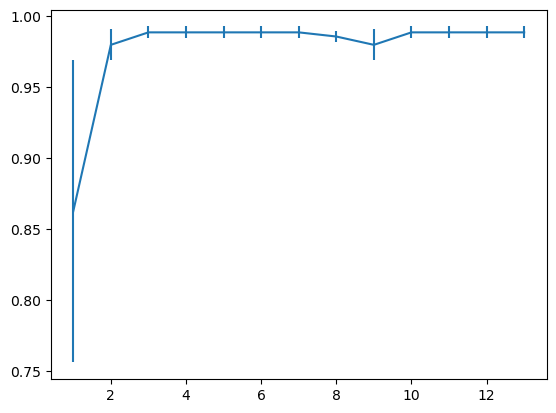

In [18]:
# 特徴量の数と精度の推移を描画
import matplotlib.pyplot as plt
plt.errorbar(range(1, 1+len(rfecv.cv_results_['mean_test_score'])),
            rfecv.cv_results_['mean_test_score'],
            yerr=rfecv.cv_results_['std_test_score'])

In [19]:
rfecv.cv_results_['mean_test_score']

array([0.8625731 , 0.97953216, 0.98830409, 0.98830409, 0.98830409,
       0.98830409, 0.98830409, 0.98538012, 0.97953216, 0.98830409,
       0.98830409, 0.98830409, 0.98830409])